<a href="https://colab.research.google.com/github/m-riddle-codes/ARA/blob/main/pd1pdl1_SMILES_to_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SMILES to properties
Run property prediction on SMILES using [chemprop](https://github.com/chemprop/chemprop), [soltrannet](https://github.com/gnina/SolTranNet), and [SMILES2Caption](https://github.com/blender-nlp/MolT5).
Most training data is from [MoleculeNet](https://moleculenet.org/full-results).

Either paste in one smiles in the input form, or create a dictionary of many smiles by editing the code block directly below.

Select Runtime / Run All to test it out.

In [ ]:
#@title SMILES input

SMILES = '' #@param {type:"string"}

#@markdown Optionally, include a name for the molecule
SMILES_name = '' #@param {type:"string"}

#@markdown SMILES2Caption produces a description of the molecule, but takes a few minutes to run
run_slow_smiles2caption = True #@param {type:"boolean"}

#@markdown The MUV tasks from MoleculeNet are only relevant for a small set of specific proteins
run_muv_tasks = True #@param {type:"boolean"}

#@markdown Download a tsv file containing all results?
download_results = True #@param {type:"boolean"}


In [ ]:
example_smiles_d = {"CHEMBL4092122": "Cc1c(CO)cccc1-c1ccccc1",
                    "CHEMBL4441950": "Cc1c(CO)cccc1-c1ccc2c(c1)OCCO2",
                    "CHEMBL4436703": "CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cncc(C#N)c1",
                    "CHEMBL5176735":"Cc1cc(CN[C@@H](CO)C(=O)O)c(OCc2cncc(C#N)c2)cc1OCc1cccc(-c2ccc3c(c2)OCCO3)c1C",
                    "CHEMBL5194902":"O=C1CC(C23CC4CC(CC(C4)C2)C3)=NN1c1ccccn1",
                   }

# use SMILES if it has been input, otherwise use the example_smiles_d above
smiles_d = {SMILES_name or "compound": SMILES} if SMILES != "" else example_smiles_d


## Install dependencies

In [ ]:
!test -d smiles_to_properties || (git clone https://github.com/hgbrian/smiles_to_properties.git && mv smiles_to_properties/* .)

Cloning into 'smiles_to_properties'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 118 (delta 6), reused 0 (delta 0), pack-reused 103
Receiving objects: 100% (118/118), 12.93 MiB | 17.08 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
!pip install rdkit==2022.3.5 --quiet
!pip install mols2grid==1.0.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.0/101.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.1 MB/s eta 0:00:00


In [ ]:
!pip install chemprop==1.5.2 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.6/166.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install soltrannet==1.0.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.1 MB/s eta 0:00:00


In [ ]:
if run_slow_smiles2caption:
    !pip install transformers==4.22.1 --quiet
    !pip install sentencepiece==0.1.97 --quiet
    !pip install t5x==0.0.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.2 MB/s eta 0:00:00
Reason for being yanked: dummy version


## Create a dataframe of SMILES

In [ ]:
from tqdm.auto import tqdm
import pandas as pd

df_smiles = pd.DataFrame(smiles_d.items(), columns=["compound", "smiles"])
display(df_smiles)

,compound,smiles
0,CHEMBL4092122,Cc1c(CO)cccc1-c1ccccc1
1,CHEMBL4441950,Cc1c(CO)cccc1-c1ccc2c(c1)OCCO2
2,CHEMBL4436703,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...
3,CHEMBL5176735,Cc1cc(CN[C@@H](CO)C(=O)O)c(OCc2cncc(C#N)c2)cc1...
4,CHEMBL5194902,O=C1CC(C23CC4CC(CC(C4)C2)C3)=NN1c1ccccn1


### Optionally, use FDA approved drugs as input to recalculate normal ranges

In [ ]:
RECALCULATE_FDA_APPROVED_DRUG_RANGES = False

if RECALCULATE_FDA_APPROVED_DRUG_RANGES:
    !test -f drugs.txt || wget https://github.com/ericminikel/cureffi/blob/gh-pages/wp-content/uploads/2013/10/drugs.txt
    df_approved = pd.read_csv("drugs.txt", sep='\t')
    df_smiles = df_approved.dropna(subset=["smiles"]).drop(columns=["cns_drug"]).rename(columns={"generic_name":"compound"})
    display(df_smiles)

## Predicting properties

### Predict logS with soltrannet


In [ ]:
import soltrannet as stn
import warnings
warnings.filterwarnings("ignore", message=".*Creating a tensor from a list of numpy.ndarrays is extremely slow")

for ix, row in df_smiles.iterrows():
    logS, _, logS_warn = next(stn.predict([row.smiles]))
    df_smiles.at[ix, "logS"] = round(logS, 3)
    df_smiles.at[ix, "logS_warn"] = logS_warn

display(df_smiles)

,compound,smiles,logS,logS_warn
0,CHEMBL4092122,Cc1c(CO)cccc1-c1ccccc1,-2.527,
1,CHEMBL4441950,Cc1c(CO)cccc1-c1ccc2c(c1)OCCO2,-3.336,
2,CHEMBL4436703,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,-6.737,
3,CHEMBL5176735,Cc1cc(CN[C@@H](CO)C(=O)O)c(OCc2cncc(C#N)c2)cc1...,-5.352,
4,CHEMBL5194902,O=C1CC(C23CC4CC(CC(C4)C2)C3)=NN1c1ccccn1,-4.069,


### Predict caption with Smiles2Caption

In [ ]:
if run_slow_smiles2caption:
    from transformers import T5Tokenizer, T5ForConditionalGeneration
    tokenizer = T5Tokenizer.from_pretrained("laituan245/molt5-large-smiles2caption", model_max_length=512)
    model = T5ForConditionalGeneration.from_pretrained('laituan245/molt5-large-smiles2caption')

    for ix, row in tqdm(df_smiles.iterrows(), total=len(df_smiles)):
        input_ids = tokenizer(row.smiles, return_tensors="pt").input_ids
        outputs = model.generate(input_ids, num_beams=5, max_length=512)
        df_smiles.at[ix, "caption"] = tokenizer.decode(outputs[0], skip_special_tokens=True)

    display(df_smiles)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

,compound,smiles,logS,logS_warn,caption
0,CHEMBL4092122,Cc1c(CO)cccc1-c1ccccc1,-2.527,,The molecule is a saturated organic heteromono...
1,CHEMBL4441950,Cc1c(CO)cccc1-c1ccc2c(c1)OCCO2,-3.336,,The molecule is a member of the class of benzo...
2,CHEMBL4436703,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,-6.737,,The molecule is a propanolamine that is 3-amin...
3,CHEMBL5176735,Cc1cc(CN[C@@H](CO)C(=O)O)c(OCc2cncc(C#N)c2)cc1...,-5.352,,The molecule is a nitrile that is hexanenitril...
4,CHEMBL5194902,O=C1CC(C23CC4CC(CC(C4)C2)C3)=NN1c1ccccn1,-4.069,,The molecule is a member of the class of tetra...


In [ ]:
df_smiles

,compound,smiles,logS,logS_warn,caption,BBB Penetration,Water solubility (log),NR-AR,NR-AR-LBD,NR-AhR,...,MUV-712,MUV-713,MUV-733,MUV-737,MUV-810,MUV-832,MUV-846,MUV-852,MUV-858,MUV-859
0,CHEMBL4092122,Cc1c(CO)cccc1-c1ccccc1,-2.527,NaN,The molecule is a saturated organic heteromono...,0.961318,-3.855862,0.027041,0.011224,0.120334,...,0.495163,0.477680,0.524034,0.441594,0.376971,0.406601,0.496218,0.665248,0.427612,0.584066
1,CHEMBL4441950,Cc1c(CO)cccc1-c1ccc2c(c1)OCCO2,-3.336,NaN,The molecule is a member of the class of benzo...,0.965847,-3.899051,0.026700,0.020941,0.303898,...,0.497323,0.457578,0.534468,0.446061,0.378486,0.415611,0.506021,0.666494,0.442614,0.585024
2,CHEMBL4436703,CCNCc1cc(C)c(OCc2cccc(-c3ccccc3)c2C)cc1OCc1cnc...,-6.737,NaN,The molecule is a propanolamine that is 3-amin...,0.926497,-4.823300,0.032792,0.034195,0.371010,...,0.492454,0.463118,0.522411,0.445051,0.389106,0.420345,0.505137,0.661741,0.431716,0.578967
3,CHEMBL5176735,Cc1cc(CN[C@@H](CO)C(=O)O)c(OCc2cncc(C#N)c2)cc1...,-5.352,NaN,The molecule is a nitrile that is hexanenitril...,0.765305,-4.286219,0.039415,0.042678,0.251464,...,0.490835,0.457098,0.530269,0.447825,0.395102,0.429543,0.507533,0.659979,0.445808,0.582034
4,CHEMBL5194902,O=C1CC(C23CC4CC(CC(C4)C2)C3)=NN1c1ccccn1,-4.069,NaN,The molecule is a member of the class of tetra...,0.997283,-4.107547,0.011087,0.005081,0.234302,...,0.473066,0.436746,0.548889,0.501445,0.416999,0.452535,0.528681,0.667323,0.439520,0.599294


In [ ]:
# Convert the DataFrame to CSV
df_smiles.to_csv('df_smiles.csv', index=False)

# Code to download the CSV file to your local machine from Google Colab
from google.colab import files
files.download('df_smiles.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Optionally, train chemprop neural network on MoleculeNet data

The neural net has been trained.
The datasets are from https://moleculenet.org/datasets-1

To retrain, add e.g., `"tox21"` to `TO_RETRAIN`.

In [ ]:
TO_RETRAIN = []

moleculenet = {"BBBP": ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv", "classification", ("p_np", "BBB Penetration")),
               "delaney-processed": ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv", "regression", ("ESOL predicted log solubility in mols per litre", "Water solubility (log)")),
               "tox21": ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz", "classification", ("", "")),
               "toxcast_data": ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/toxcast_data.csv.gz", "classification", ("", "")),
               "SAMPL": ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/SAMPL.csv", "regression", ("expt", "Hydration free energy")),
               "Lipophilicity": ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv", "regression", ("exp", "Lipophilicity")),
               "clintox": ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/clintox.csv.gz", "classification", ("FDA_APPROVED", "FDA Approved")),
               "sider": ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/sider.csv.gz", "classification", ("","")),
               "muv": ("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/muv.csv.gz", "classification", ("", "")),
               }

for dataset in TO_RETRAIN:
    url, dataset_type, (target_columns, rename_target_columns) = moleculenet[dataset]

    !(test -f {dataset}.csv || wget {url}) && (test -f {dataset}.csv.gz && gunzip {dataset}.csv.gz)

    print(f"training {dataset} {target_columns}")
    arg_target_columns = f'--target_columns "{target_columns}"' if target_columns != "" else ""
    !chemprop_train --data_path {dataset}.csv --dataset_type {dataset_type} --save_dir {dataset}_checkpoints --smiles_columns smiles --ignore_columns mol_id {arg_target_columns}

### Optionally, test moleculenet
For completeness, run the neural net on all the training data.

In [ ]:
TO_RETEST = []

for dataset in TO_RETEST:
    url, dataset_type, target_columns = moleculenet[dataset]
    print(f"predicting {dataset} {target_columns}")
    !chemprop_predict --test_path {dataset}.csv --checkpoint_dir {dataset}_checkpoints --smiles_column smiles --preds_path {dataset}_preds

### Run chemprop model on all SMILES

In [ ]:
df_smiles.to_csv("df_smiles.csv", index=None)

for dataset, (url, dataset_type, target_columns) in moleculenet.items():
    if dataset == "muv" and not run_muv_tasks: continue
    !chemprop_predict --test_path df_smiles.csv --checkpoint_dir {dataset}_checkpoints --smiles_column smiles --preds_path df_{dataset}_preds.csv
    !mv df_{dataset}_preds.csv df_smiles.csv

df_smiles = pd.read_csv("df_smiles.csv").rename(columns={old:new for old, new in [v[2] for v in moleculenet.values()]})

Loading training args
Setting molecule featurization parameters to default.
Loading data
5it [00:00, 18558.87it/s]
100% 5/5 [00:00<00:00, 37516.14it/s]
Validating SMILES
Test size = 5
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0% 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loadi

## Create plots

Show either separate barplots, or one stripplot for properties.
5th and 95th percentile lines are drawn as dashed lines for all FDA approved drugs to show the normal range for drugs.

- Solubility
  - **Water solubility (log)**: ESOL predicted log solubility in mols per litre
  - **logS**: aqueous solubility ([soltrannet](https://pubs.acs.org/doi/10.1021/acs.jcim.1c00331))
  - **Hydration free energy**: data from [FreeSolv](https://github.com/MobleyLab/FreeSolv)
- Blood brain barrier penetration
  - **BBB Penetration**: Binary labels of blood-brain barrier penetration (permeability)
- [Toxicity](https://www.researchgate.net/publication/290509018_Tox21Challenge_to_Build_Predictive_Models_of_Nuclear_Receptor_and_Stress_Response_Pathways_as_Mediated_by_Exposure_to_Environmental_Chemicals_and_Drugs/fulltext/5699cdfe08aeeea98594b348/Tox21Challenge-to-Build-Predictive-Models-of-Nuclear-Receptor-and-Stress-Response-Pathways-as-Mediated-by-Exposure-to-Environmental-Chemicals-and-Drugs.pdf)
  - **CT_TOX**: The ClinTox dataset compares drugs approved by the FDA and
  drugs that have failed clinical trials for toxicity reasons.
  - **NR-AR**: Androgen receptor, full length
  - **NR-AR-LBD**: Androgen receptor, LBD
  - **NR-AhR**: Aryl hydrocarbon receptor
  - **NR-Aromatase**: Aromatase
  - **NR-ER**: Estrogen receptor alpha, full length
  - **NR-ER-LBD**: Estrogen receptor alpha, LBD
  - **NR-PPAR-gamma**: Peroxisome proliferator-activated receptor
gamma
  - **SR-ARE**: Nuclear factor (erythroid-derived 2)-like
2/antioxidant responsive element
  - **SR-ATAD5**: ATAD5
  - **SR-HSE**: Heat shock factor response element
  - **SR-MMP**: Mitochondrial membrane potential
  - **SR-p53**: p53
- FDA Approval
  - **FDA Approved**: The ClinTox dataset compares drugs approved by the FDA and
  drugs that have failed clinical trials for toxicity reasons.
- [MUV](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0407-y/tables/8) (subset of PubChem BioAssay, designed for validation of virtual screening techniques)
  - **MUV-466**: S1P1 rec.
  - **MUV-548**: PKA
  - **MUV-600**: SF1
  - **MUV-644**: Rho-Kinase2
  - **MUV-652**: HIV RT-RNase
  - **MUV-689**: Eph rec. A4
  - **MUV-692**: SF1
  - **MUV-712**: HSP 90
  - **MUV-713**: ER-a-coact. bind.
  - **MUV-733**: ER-β-coact. bind.
  - **MUV-737**: ER-a-coact. bind.
  - **MUV-810**: FAK
  - **MUV-832**: Cathepsin G
  - **MUV-846**: FXIa
  - **MUV-852**: FXIIa
  - **MUV-858**: D1 rec.
  - **MUV-859**: M1 rec.


In [ ]:
if RECALCULATE_FDA_APPROVED_DRUG_RANGES:
    def q5(x): return x.quantile(0.05)
    def q95(x): return x.quantile(0.95)
    FDA_approved_drug_range = df_smiles.set_index(list(set(df_smiles.columns) & {"compound", "smiles", "caption", "logS_warn"})).agg([q5, q95]).transpose()
    FDA_approved_drug_range.to_csv("FDA_approved_drug_ranges.tsv", sep='\t')
    display(FDA_approved_drug_range)
else:
    FDA_approved_drug_range = pd.read_csv("FDA_approved_drug_ranges.tsv", sep='\t', index_col=0)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid");

df_smiles_melt = df_smiles.melt(id_vars = set(df_smiles.columns) & {"compound", "smiles", "caption", "logS_warn"})

graphs = {"Solubility": ["Water solubility (log)", "logS", "Hydration free energy"],
          "Blood Brain Barrier Penetration": ["BBB Penetration"],
          "Toxicity": ["CT_TOX", "NR-AR","NR-AR-LBD","NR-AhR","NR-Aromatase","NR-ER","NR-ER-LBD","NR-PPAR-gamma","SR-ARE","SR-ATAD5","SR-HSE","SR-MMP","SR-p53"],
          "FDA Approval": ["FDA Approved"],
          "MUV": ["MUV-466", "MUV-548", "MUV-600", "MUV-644", "MUV-652", 'MUV-689', "MUV-692", "MUV-712", "MUV-713", "MUV-733", "MUV-737", "MUV-810", "MUV-832", "MUV-846", "MUV-852", "MUV-858", "MUV-859",],
          }

if not run_muv_tasks:
  del graphs["MUV"]

### Plot format 1: barcharts

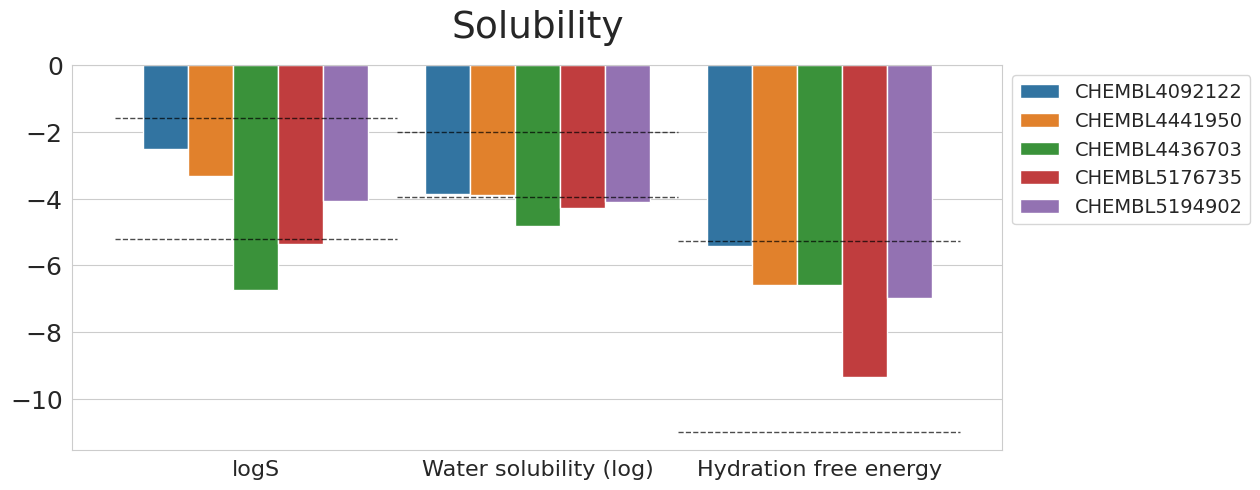

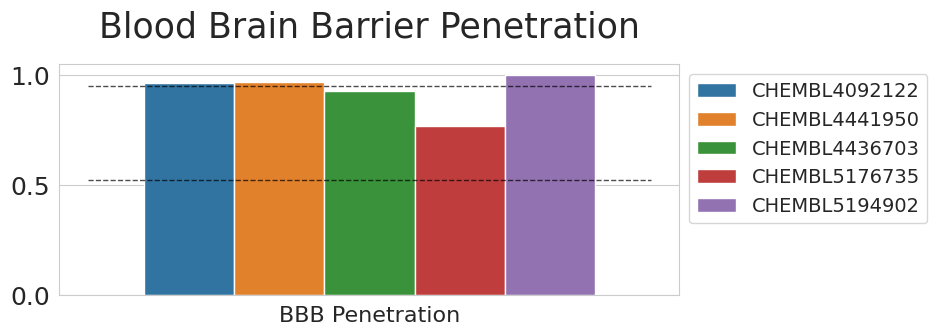

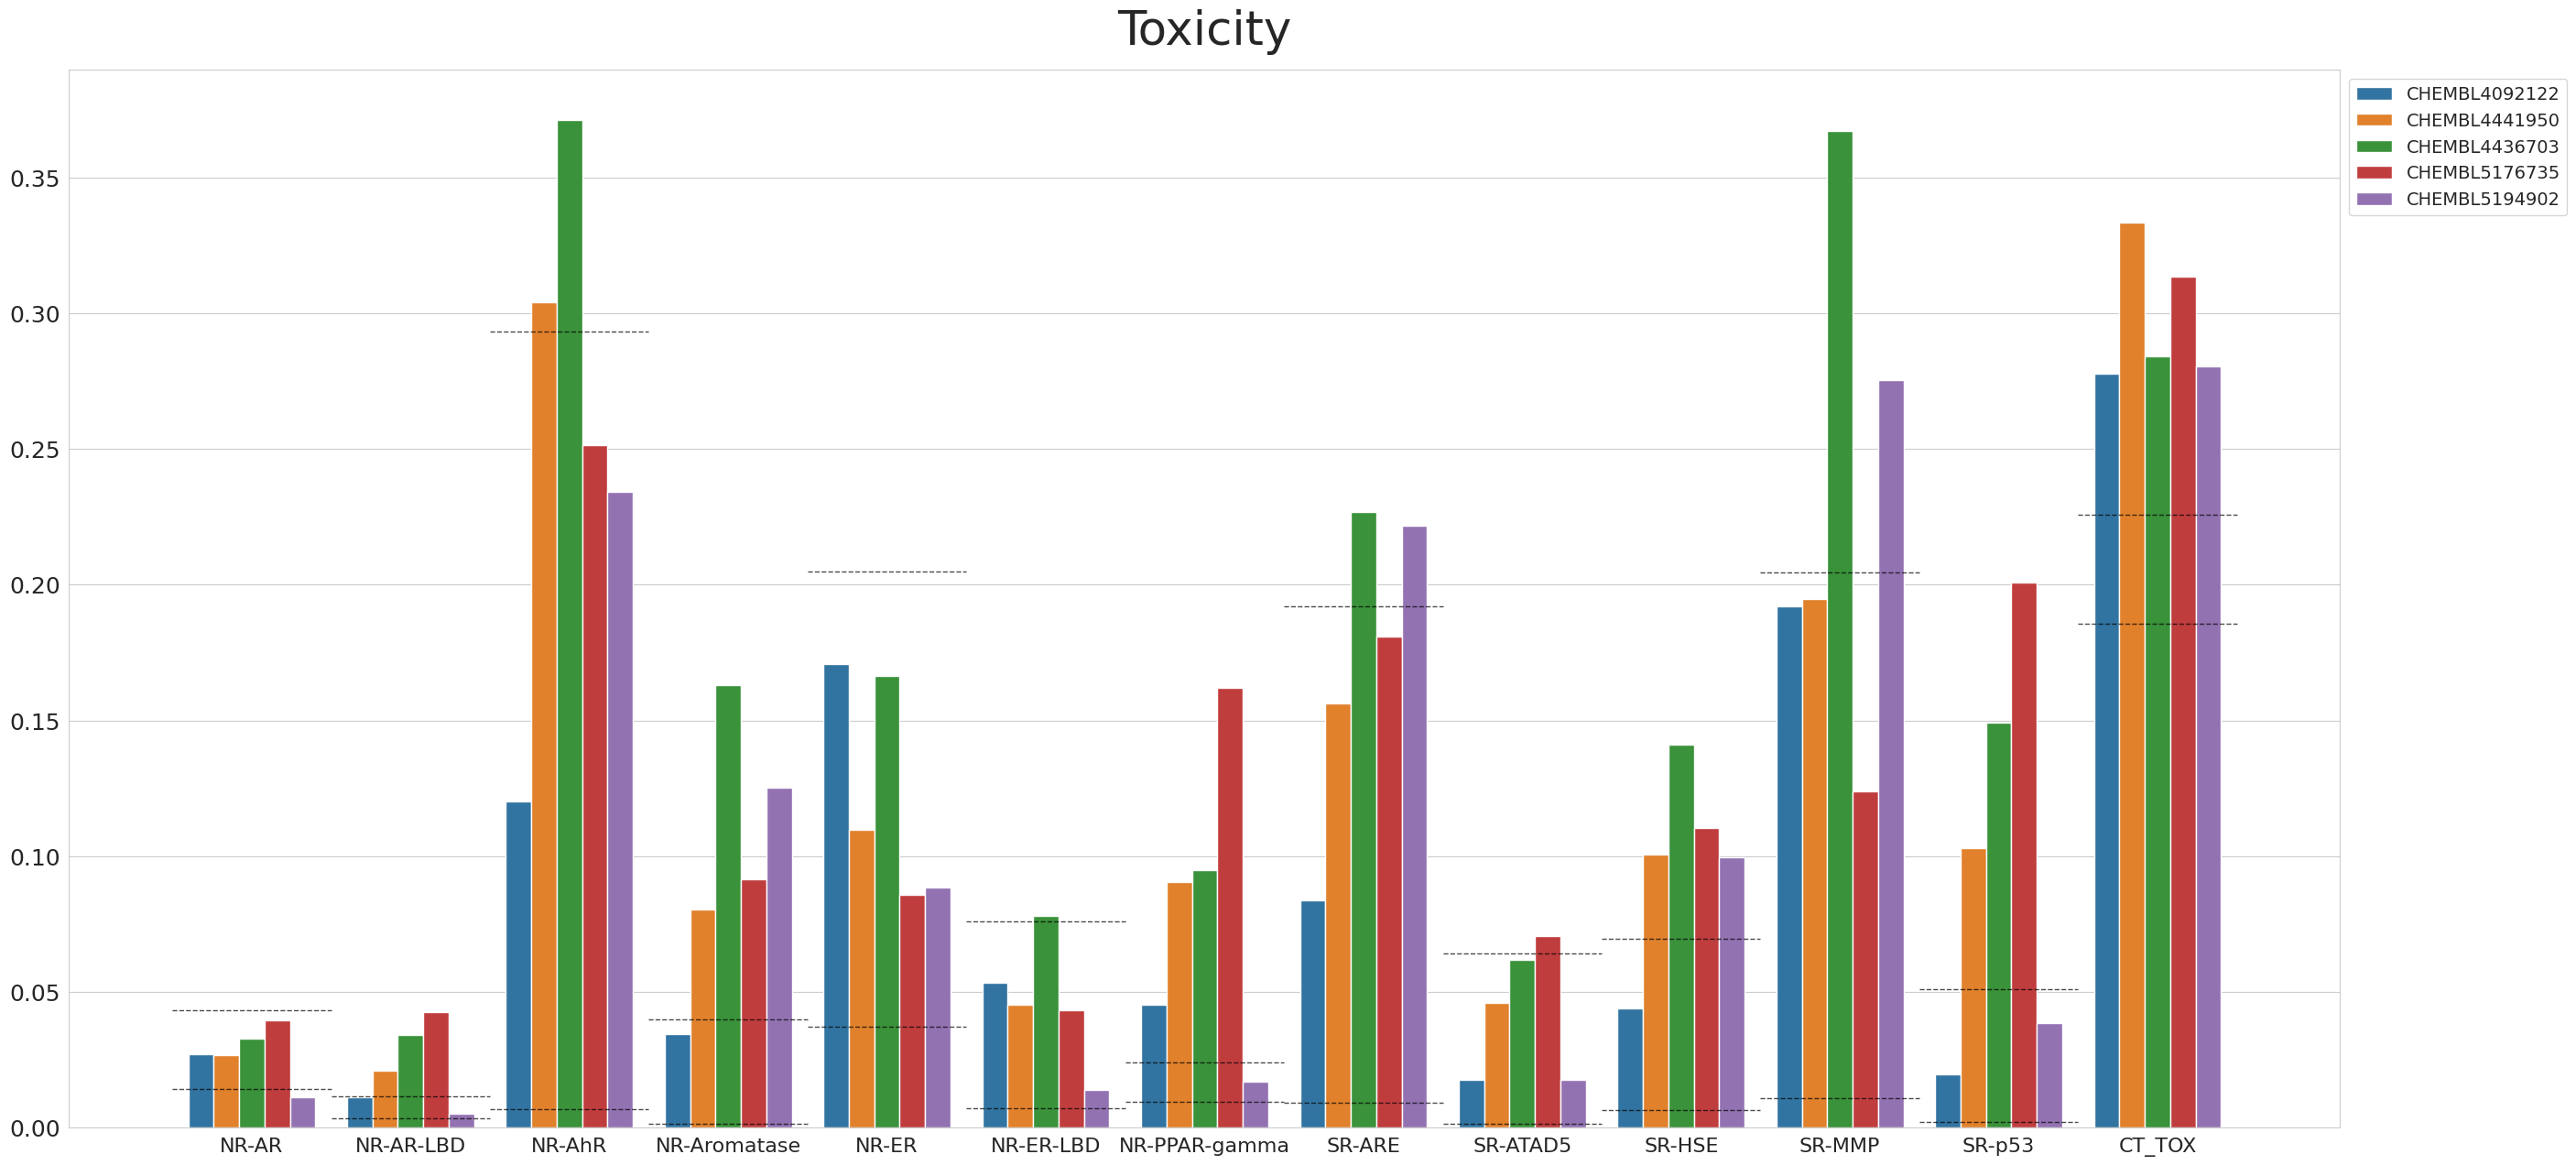

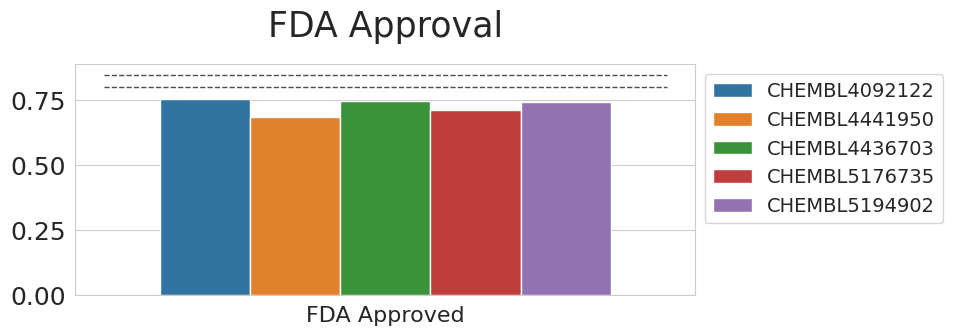

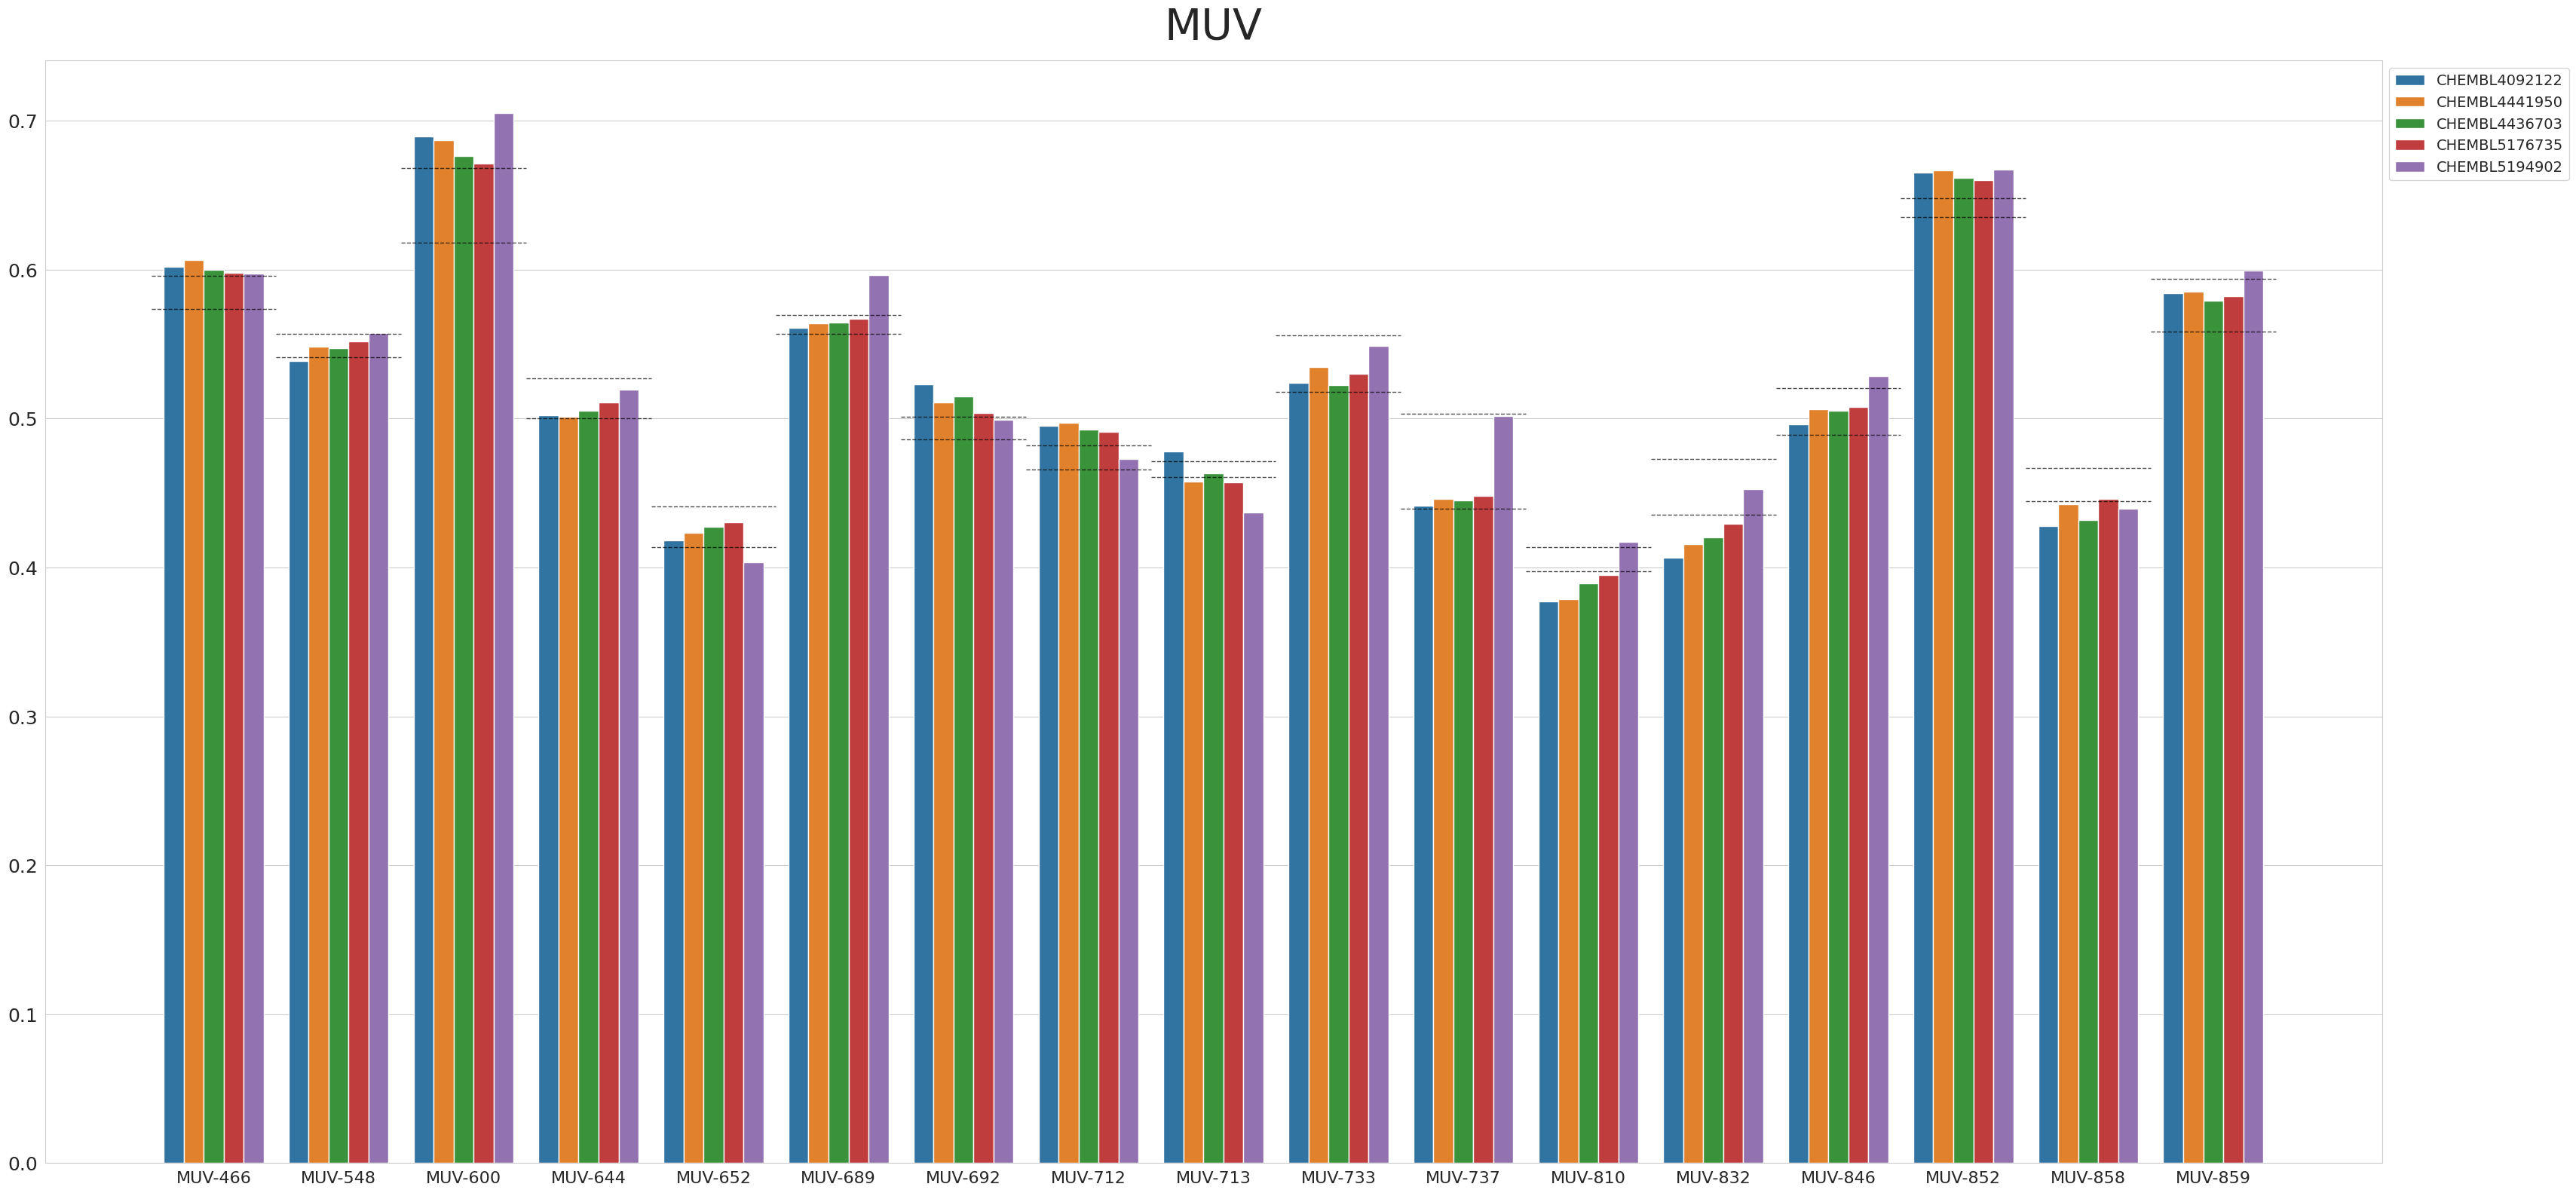

In [ ]:
for title, cols in graphs.items():
    df_plot = df_smiles_melt.loc[lambda df: df.variable.isin(cols)]
    f, ax = plt.subplots(figsize=(6+2*df_plot.variable.nunique(), 2 + 1*df_plot.variable.nunique()));
    sns.barplot(data=df_plot, x="variable", y="value", hue="compound");

    ax.set_title(title, pad=20);
    ax.title.set_fontsize(24 + 1*df_plot.variable.nunique());
    ax.tick_params(axis='x', labelsize=16);
    ax.tick_params(axis='y', labelsize=18);
    ax.set_ylabel('');
    ax.set_xlabel('');

    ax.legend(loc='upper left', fontsize=14, bbox_to_anchor=(1, 1));

    for n, x in enumerate([x.get_text() for x in ax.get_xticklabels()]):
        ax.hlines(y=FDA_approved_drug_range.loc[x].q5, color='black', linewidth=1, alpha=.7, xmin = n-0.5, xmax = n+0.5, linestyles='dashed')
        ax.hlines(y=FDA_approved_drug_range.loc[x].q95, color='black', linewidth=1, alpha=.7, xmin = n-0.5, xmax = n+0.5, linestyles='dashed')
        #ax.vlines(x=n, color='black', alpha=0.1, linewidth=10, ymin = FDA_approved_drug_range.loc[x].q5, ymax = FDA_approved_drug_range.loc[x].q95, linestyles='solid')


### Plot format 2: stripplot

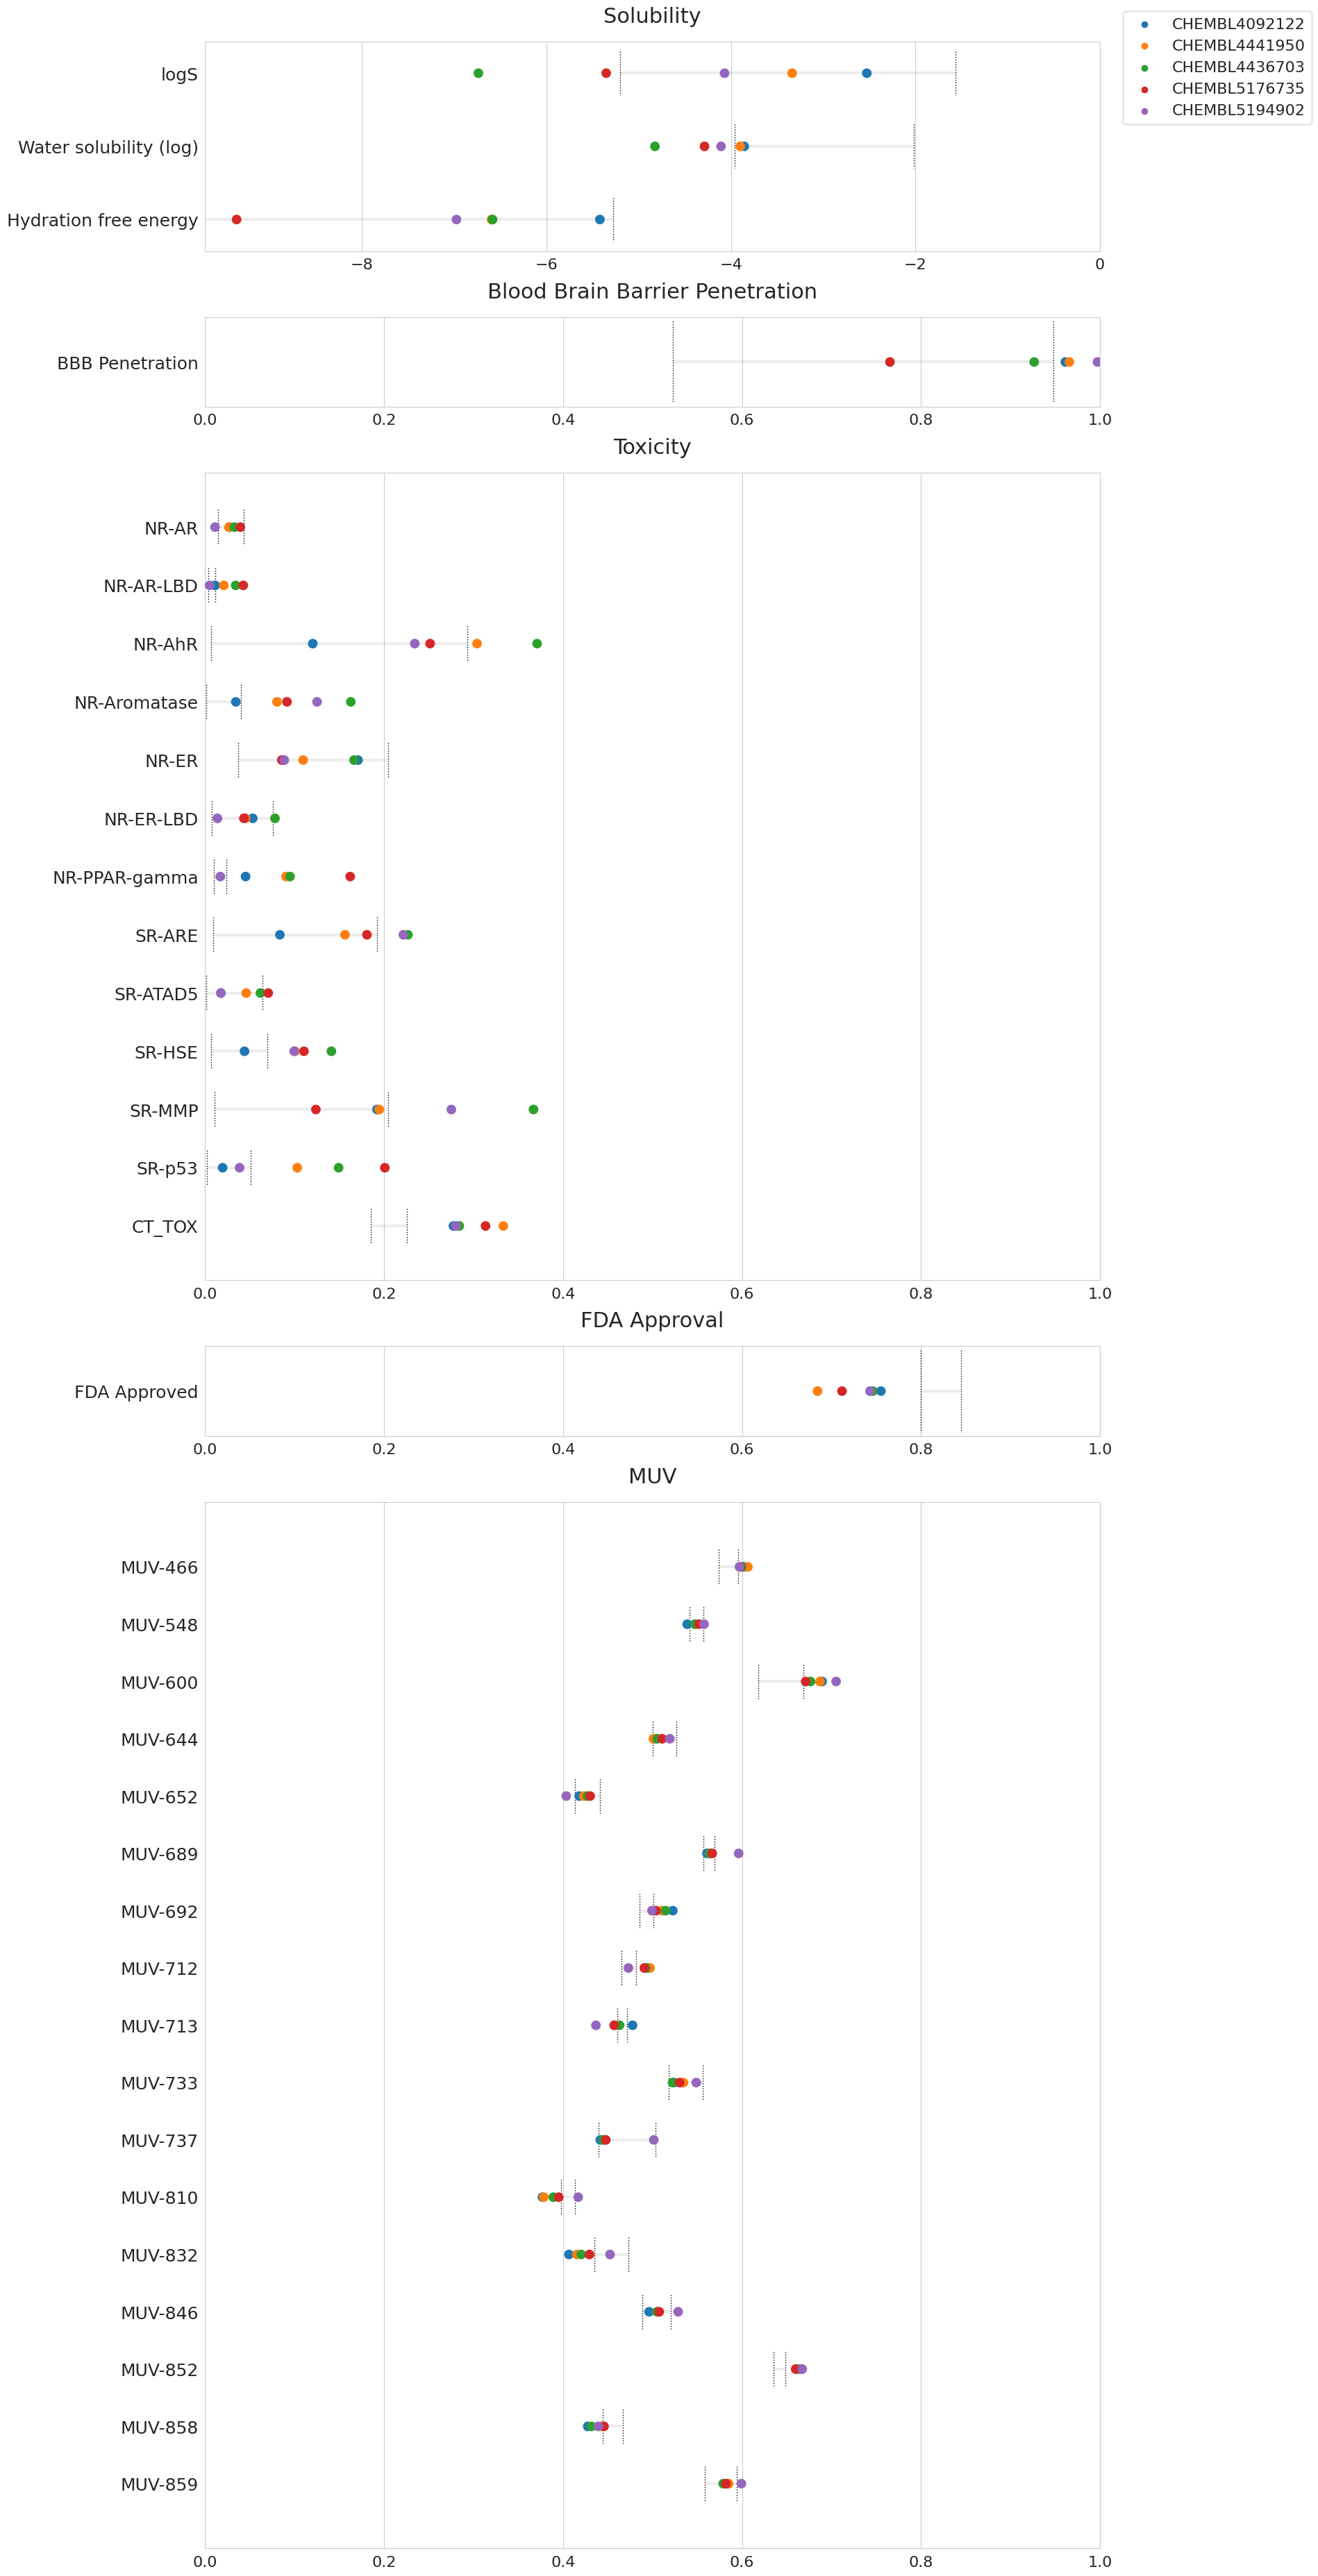

In [ ]:
f, axs = plt.subplots(len(graphs), 1, constrained_layout=True,
                      gridspec_kw={'height_ratios': [0.5 + len(gv) for g, gv in graphs.items()]},
                      figsize=(16, 2 + 1*sum(len(gv) for g, gv in graphs.items())));

for ax_n, (title, cols) in enumerate(graphs.items()):
    ax = axs[ax_n]
    df_plot = df_smiles_melt.loc[lambda df: df.variable.isin(cols)]
    sns.stripplot(data=df_plot, x="value", y="variable", hue="compound", jitter=False, size=10, ax=ax);

    ax.set_title(title, pad=20);
    ax.title.set_fontsize(22);
    ax.tick_params(axis='x', labelsize=16);
    ax.tick_params(axis='y', labelsize=18);
    ax.set_ylabel('');
    ax.set_xlabel('');

    if all(0 <= v <= 1 for v in df_plot.value): ax.set_xlim(0, 1);
    elif all(v <= 0 for v in df_plot.value): ax.set_xlim(None, 0);
    elif all(v >= 0 for v in df_plot.value): ax.set_xlim(0, None);

    ax.legend().remove()

    for n, y in enumerate([y.get_text() for y in ax.get_yticklabels()]):
        ax.vlines(x=FDA_approved_drug_range.loc[y].q5, color='black', linewidth=1, ymin = n-0.3, ymax = n+0.3, linestyles='dotted')
        ax.vlines(x=FDA_approved_drug_range.loc[y].q95, color='black', linewidth=1, ymin = n-0.3, ymax = n+0.3, linestyles='dotted')
        ax.hlines(y=n, color='black', alpha=0.07, linewidth=3, xmin = FDA_approved_drug_range.loc[y].q5, xmax = FDA_approved_drug_range.loc[y].q95, linestyles='solid')

handles, labels = ax.get_legend_handles_labels();
f.legend(handles, labels, loc='upper left', fontsize=16, bbox_to_anchor=(1, 1));

## Create mols2grid grid

In [ ]:
import mols2grid

mols2grid.display(df_smiles.applymap(lambda x: round(x, 3) if isinstance(x, float) else x),
                  smiles_col="smiles",
                  tooltip=None,
                  tooltip_trigger="hover",
                  tooltip_placement="right")

MolGridWidget()

## Download tsv file with all results

In [ ]:
if download_results:
    from google.colab import files
    df_smiles.applymap(lambda x: round(x, 4) if isinstance(x, float) else x).to_csv("df_smiles.tsv", index=None, sep='\t')
    files.download('df_smiles.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>